In [3]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"
import tensorflow as tf

__weights_dict = dict()

is_train = False

def load_weights(weight_file):
    import numpy as np

    if weight_file == None:
        return

    try:
        weights_dict = np.load(weight_file).item()
    except:
        weights_dict = np.load(weight_file, encoding='bytes').item()

    return weights_dict


def KitModel(dist,direction,weight_file = None):
    tf.reset_default_graph()
    with tf.device("/device:CPU:0"):

        global __weights_dict
        __weights_dict = load_weights(weight_file)

#         input           = tf.placeholder(tf.float32, shape = (None, 512, 512, 8), name = 'input')

# Variable for trainable later
        with tf.name_scope('preprocess'):
            raw_input       = tf.Variable(tf.zeros((1, 512, 512, 5)), name = 'raw_input')
            raw_max_height = tf.slice(raw_input,[0,0,0,0],[1,512,512,1])
            raw_mean_height = tf.slice(raw_input,[0,0,0,1],[1,512,512,1])
            raw_cnt = tf.slice(raw_input,[0,0,0,2],[1,512,512,1])
            raw_max_int = tf.slice(raw_input,[0,0,0,3],[1,512,512,1])
            raw_mean_int = tf.slice(raw_input,[0,0,0,4],[1,512,512,1])


            # clipping does not have gradient
            max_height = tf.clip_by_value(raw_max_height,tf.scalar_mul(-5,tf.ones((1,512,512,1))),tf.scalar_mul(5,tf.ones((1,512,512,1))))
            mean_height = tf.clip_by_value(raw_mean_height,max_height, tf.scalar_mul(5,tf.ones((1,512,512,1))))
            cnt = tf.clip_by_value(raw_cnt,tf.zeros((1,512,512,1)),tf.scalar_mul(5,tf.ones((1,512,512,1))))
            direction = tf.constant(direction,dtype=tf.float32)
            max_int = tf.clip_by_value(raw_max_int,tf.zeros((1,512,512,1)),tf.scalar_mul(5,tf.ones((1,512,512,1))))
            mean_int = tf.clip_by_value(raw_mean_int,max_int, tf.scalar_mul(5,tf.ones((1,512,512,1))))
            dist = tf.constant(dist,dtype=tf.float32)
            nonempty = tf.sign(tf.clip_by_value(cnt-1e-6,0,5))

    #         max_height = tf.tanh(raw_max_height/5.0*3.0)*5
    #         mean_height = tf.clip_by_value(tf.tanh(raw_mean_height/5.0*3.0)*5.0,max_height, tf.scalar_mul(5,tf.ones((1,512,512,1))))
    #         cnt = tf.clip_by_value(raw_cnt,tf.zeros((1,512,512,1)),tf.scalar_mul(5,tf.ones((1,512,512,1))))
    #         direction = tf.constant(direction,dtype=tf.float32)
    #         max_int = tf.clip_by_value(tf.tanh(raw_max_int/5.0*3.0)*5.0,tf.zeros((1,512,512,1)),tf.scalar_mul(5,tf.ones((1,512,512,1))))
    #         mean_int = tf.clip_by_value(tf.tanh(raw_mean_int/5.0*3.0)*5.0,max_int, tf.scalar_mul(5,tf.ones((1,512,512,1))))
    #         dist = tf.constant(dist,dtype=tf.float32)
#             nonempty = tf.constant(nonempt,dtype=tf.float32)
    #         nonempty = tf.clip_by_value(cnt,0,1)
        with tf.name_scope('structure_logic'):
            input = tf.concat([max_height,mean_height,cnt,direction,max_int,mean_int,dist,nonempty],3)
    #         input           = tf.Variable(tf.zeros((1, 512, 512, 8)), name = 'input')
            conv1_1_pad     = tf.pad(input, paddings = [[0L, 0L], [1L, 1L], [1L, 1L], [0L, 0L]])
            conv1_1         = convolution(conv1_1_pad, group=1, strides=[2, 2], padding='VALID', name='conv1_1')
            relu1_1         = tf.nn.relu(conv1_1, name = 'relu1_1')
            conv1_2_pad     = tf.pad(relu1_1, paddings = [[0L, 0L], [1L, 1L], [1L, 1L], [0L, 0L]])
            conv1_2         = convolution(conv1_2_pad, group=1, strides=[1, 1], padding='VALID', name='conv1_2')
            relu1_2         = tf.nn.relu(conv1_2, name = 'relu1_2')
            conv2_1_pad     = tf.pad(relu1_2, paddings = [[0L, 0L], [1L, 1L], [1L, 1L], [0L, 0L]])
            conv2_1         = convolution(conv2_1_pad, group=1, strides=[2, 2], padding='VALID', name='conv2_1')
            conv2_1_relu    = tf.nn.relu(conv2_1, name = 'conv2_1_relu')
            conv2_2_pad     = tf.pad(conv2_1_relu, paddings = [[0L, 0L], [1L, 1L], [1L, 1L], [0L, 0L]])
            conv2_2         = convolution(conv2_2_pad, group=1, strides=[1, 1], padding='VALID', name='conv2_2')
            conv2_2_relu    = tf.nn.relu(conv2_2, name = 'conv2_2_relu')
            conv3_1_pad     = tf.pad(conv2_2_relu, paddings = [[0L, 0L], [1L, 1L], [1L, 1L], [0L, 0L]])
            conv3_1         = convolution(conv3_1_pad, group=1, strides=[2, 2], padding='VALID', name='conv3_1')
            conv3_1_relu    = tf.nn.relu(conv3_1, name = 'conv3_1_relu')
            conv4_1_pad     = tf.pad(conv3_1_relu, paddings = [[0L, 0L], [1L, 1L], [1L, 1L], [0L, 0L]])
            conv4_1         = convolution(conv4_1_pad, group=1, strides=[2, 2], padding='VALID', name='conv4_1')
            conv4_1_relu    = tf.nn.relu(conv4_1, name = 'conv4_1_relu')
            conv5_1_pad     = tf.pad(conv4_1_relu, paddings = [[0L, 0L], [1L, 1L], [1L, 1L], [0L, 0L]])
            conv5_1         = convolution(conv5_1_pad, group=1, strides=[2, 2], padding='VALID', name='conv5_1')
            conv5_1_relu    = tf.nn.relu(conv5_1, name = 'conv5_1_relu')
        #     refine5_deconv_pad = tf.pad(conv5_1_relu, paddings = [[0L, 0L], [1L, 1L], [1L, 1L], [0L, 0L]])
            refine5_deconv = deconvolution(conv5_1_relu,output_shape=(1, 32, 32, 128),strides=[1,2,2,1],padding='SAME',name='refine5_deconv')
            refine5_deconv_relu = tf.nn.relu(refine5_deconv, name = 'refine5_deconv_relu')

            refine4_concat  = tf.concat([conv4_1_relu, refine5_deconv_relu], 3, name = 'refine4_concat')
            refine4_conv_3x3_2_pad = tf.pad(refine4_concat, paddings = [[0L, 0L], [1L, 1L], [1L, 1L], [0L, 0L]])
            refine4_conv_3x3_2 = convolution(refine4_conv_3x3_2_pad, group=1, strides=[1, 1], padding='VALID', name='refine4_conv_3x3_2')
            refine4_conv_3x3_2_relu = tf.nn.relu(refine4_conv_3x3_2, name = 'refine4_conv_3x3_2_relu')

            refine4_deconv = deconvolution(refine4_conv_3x3_2_relu,output_shape=(1, 64, 64, 96),strides=[1,2,2,1],padding='SAME',name='refine4_deconv')
            refine4_deconv_relu = tf.nn.relu(refine4_deconv, name = 'refine4_deconv_relu')

            refine3_concat  = tf.concat([conv3_1_relu, refine4_deconv_relu], 3, name = 'refine3_concat')
            refine3_conv_3x3_2_pad = tf.pad(refine3_concat, paddings = [[0L, 0L], [1L, 1L], [1L, 1L], [0L, 0L]])
            refine3_conv_3x3_2 = convolution(refine3_conv_3x3_2_pad, group=1, strides=[1, 1], padding='VALID', name='refine3_conv_3x3_2')
            refine3_conv_3x3_2_relu = tf.nn.relu(refine3_conv_3x3_2, name = 'refine3_conv_3x3_2_relu')

            refine3_deconv = deconvolution(refine3_conv_3x3_2_relu,output_shape=(1, 128, 128, 64),strides=[1,2,2,1],padding='SAME',name='refine3_deconv')
            refine3_deconv_relu = tf.nn.relu(refine3_deconv, name = 'refine3_deconv_relu')

            refine2_concat  = tf.concat([conv2_2_relu, refine3_deconv_relu], 3, name = 'refine2_concat')
            refine2_conv_3x3_2_pad = tf.pad(refine2_concat, paddings = [[0L, 0L], [1L, 1L], [1L, 1L], [0L, 0L]])
            refine2_conv_3x3_2 = convolution(refine2_conv_3x3_2_pad, group=1, strides=[1, 1], padding='VALID', name='refine2_conv_3x3_2')
            refine2_conv_3x3_2_relu = tf.nn.relu(refine2_conv_3x3_2, name = 'refine2_conv_3x3_2_relu')

            refine2_deconv = deconvolution(refine2_conv_3x3_2_relu,output_shape=(1, 256, 256, 48),strides=[1,2,2,1],padding='SAME',name='refine2_deconv')
            refine2_deconv_relu = tf.nn.relu(refine2_deconv, name = 'refine2_deconv_relu')

            refine1_concat  = tf.concat([relu1_2, refine2_deconv_relu], 3, name = 'refine1_concat')
            refine1_conv_3x3_2_pad = tf.pad(refine1_concat, paddings = [[0L, 0L], [1L, 1L], [1L, 1L], [0L, 0L]])
            refine1_conv_3x3_2 = convolution(refine1_conv_3x3_2_pad, group=1, strides=[1, 1], padding='VALID', name='refine1_conv_3x3_2')
            refine1_conv_3x3_2_relu = tf.nn.relu(refine1_conv_3x3_2, name = 'refine1_conv_3x3_2_relu')
            predict = deconvolution(refine1_conv_3x3_2_relu,output_shape=(1, 512, 512, 12),strides=[1,2,2,1],padding='SAME',name='predict')

        with tf.name_scope('category_post'):
            mask = tf.slice(input,[0,0,0,7],[1,512,512,1])

            category_pt = tf.slice(predict,[0,0,0,0],[1,512,512,1])
            category_all = tf.sigmoid(category_pt)
            category = tf.multiply(category_all, mask)

            partial_cat = tf.slice(category,[0,150,150,0],[1,200,200,1])
    return raw_input,input, predict, category, partial_cat


def convolution(input, name, group, **kwargs):
    w = tf.Variable(__weights_dict[name]['weights'], trainable=is_train, name=name + "_weight")
    if group == 1:
        layer = tf.nn.convolution(input, w, **kwargs)
    else:
        weight_groups = tf.split(w, num_or_size_splits=group, axis=-1)
        xs = tf.split(input, num_or_size_splits=group, axis=-1)
        convolved = [tf.nn.convolution(x, weight, **kwargs) for
                    (x, weight) in zip(xs, weight_groups)]
        layer = tf.concat(convolved, axis=-1)

    if 'bias' in __weights_dict[name]:
        b = tf.Variable(__weights_dict[name]['bias'], trainable=is_train, name=name + "_bias")
        layer = layer + b
#         print 'b:', name, b.get_shape()
#         print 'layer:', name, layer.get_shape()
    return layer


def deconvolution(input, name, **kwargs):
    w = tf.Variable(__weights_dict[name]['weights'], trainable=is_train, name=name + "_weight")
    
    layer = tf.nn.conv2d_transpose(input,w,**kwargs)
    
    if 'bias' in __weights_dict[name]:
        b = tf.Variable(__weights_dict[name]['bias'], trainable=is_train, name=name + "_bias")
#         print 'b:', name, b.get_shape()
#         print 'layer:', name, layer.get_shape()
        layer = layer + b
    return layer

In [4]:
import numpy as np
features = np.loadtxt('../../percpt/features/features_0.out')
features = np.swapaxes(features,0,1)
features = np.reshape(features,(1,512,512,8))
direction = np.reshape(features[:,:,:,3],(1,512,512,1))
dist = np.reshape(features[:,:,:,6],(1,512,512,1))
nonempt = np.reshape(features[:,:,:,7],(1,512,512,1))

In [5]:
raw_input,input,predict,cat, partial_cat = KitModel(dist,direction,weight_file='segcnn.npy')

In [6]:
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.333)
with tf.Session(config=tf.ConfigProto(gpu_options=gpu_options)) as sess:
    sess.run(tf.global_variables_initializer())
    category,out = sess.run([cat,predict],feed_dict={input:features})

In [10]:
from tools import *
%matplotlib inline

In [11]:
objs = read_objs()

IOError: [Errno 2] No such file or directory: '/data/yulongc/apollo/data/percpt/builder.out'

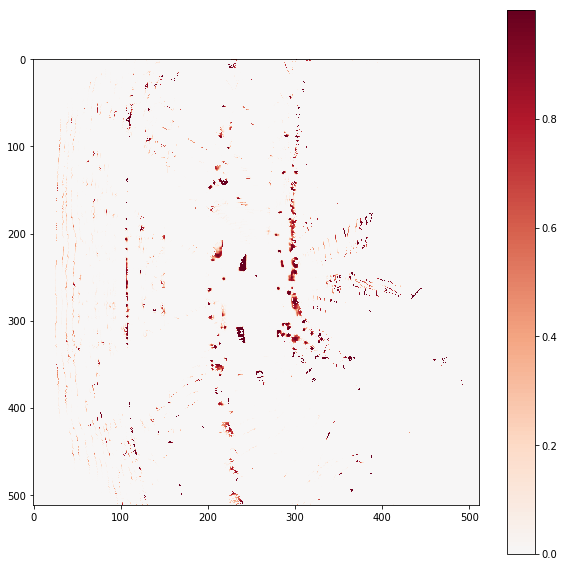

In [13]:
draw_feature(category)
# draw_annotated_feature(category,objs)

In [14]:
raw_features = features[:,:,:,[0,1,2,4,5]]
raw_features.shape

(1, 512, 512, 5)

In [15]:
x = tf.placeholder(tf.float32, raw_input.shape)

x_hat = raw_input # our trainable adversarial input
assign_op = tf.assign(x_hat, x)

learning_rate = tf.placeholder(tf.float32, ())
y_hat = tf.placeholder(tf.float32, cat.shape)

# loss = tf.losses.absolute_difference(predict,y_hat)
# loss = tf.losses.absolute_difference(tf.zeros(cat.shape),cat)
loss = tf.reduce_sum(tf.clip_by_value(tf.subtract(cat,y_hat),0,1))
optim_step = tf.train.GradientDescentOptimizer(
    learning_rate).minimize(loss, var_list=[x_hat])

epsilon = tf.placeholder(tf.float32, ())

below = x - epsilon
above = x + epsilon
projected = tf.clip_by_value(tf.clip_by_value(x_hat, below, above), -5, 5)
with tf.control_dependencies([projected]):
    project_step = tf.assign(x_hat, projected)

In [16]:
demo_epsilon = 0.01 # a really small perturbation
demo_lr = 1e-4
demo_steps = 100
demo_target = 0.4*np.ones(cat.shape)

with tf.Session(config=tf.ConfigProto(gpu_options=gpu_options)) as sess:
    
    # initialization step
    sess.run(tf.global_variables_initializer())
    sess.run(assign_op, feed_dict={x: raw_features})

    # projected gradient descent
    for i in range(demo_steps):
        # gradient descent step
        _, loss_value = sess.run(
            [optim_step, loss],
            feed_dict={learning_rate: demo_lr, y_hat: demo_target})
        # project step
        sess.run(project_step, feed_dict={x: raw_features, epsilon: demo_epsilon})
        if (i+1) % 10 == 0:
            print('step %d, loss=%g' % (i+1, loss_value))


    adv = x_hat.eval()

step 10, loss=650.336
step 20, loss=551.137
step 30, loss=474.835
step 40, loss=436.379
step 50, loss=400.02
step 60, loss=367.727
step 70, loss=345.432
step 80, loss=329.015
step 90, loss=318.388
step 100, loss=296.367


In [23]:
with tf.Session(config=tf.ConfigProto(gpu_options=gpu_options)) as sess:
    sess.run(tf.global_variables_initializer())
    adv_category,adv_out,adv_features = sess.run([cat,predict,input],feed_dict={raw_input:adv})

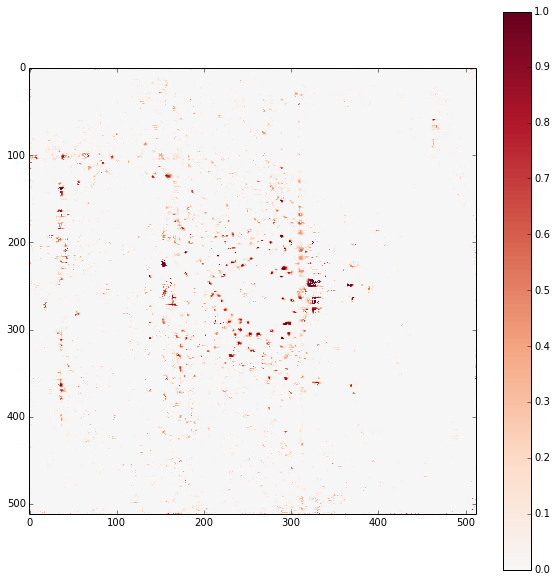

0.013345824 0.010939893


In [24]:
draw_feature(adv_category)
print category.mean(), adv_category.mean()

In [107]:
np.save('adv_input.npy',adv_features)

In [ ]:
adv_obs = read_objs()

In [27]:
import numpy as np

for j in range(500):
    features = np.loadtxt('/data/yulongc/apollo/data/percpt/features/features_{0}.out'.format(j))
    features = np.swapaxes(features,0,1)
    features = np.reshape(features,(1,512,512,8))
    direction = np.reshape(features[:,:,:,3],(1,512,512,1))
    dist = np.reshape(features[:,:,:,6],(1,512,512,1))
    nonempt = np.reshape(features[:,:,:,7],(1,512,512,1))

    raw_input,input,predict,cat, partial_cat = KitModel(dist,direction,weight_file='segcnn.npy')

    gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.333)
    with tf.Session(config=tf.ConfigProto(gpu_options=gpu_options)) as sess:
        sess.run(tf.global_variables_initializer())
        category,out = sess.run([cat,predict],feed_dict={input:features})

    raw_features = features[:,:,:,[0,1,2,4,5]]
    # raw_features.shape

    x = tf.placeholder(tf.float32, raw_input.shape)

    x_hat = raw_input # our trainable adversarial input
    assign_op = tf.assign(x_hat, x)

    learning_rate = tf.placeholder(tf.float32, ())
    y_hat = tf.placeholder(tf.float32, cat.shape)

    # loss = tf.losses.absolute_difference(predict,y_hat)
    # loss = tf.losses.absolute_difference(tf.zeros(cat.shape),cat)
    loss = tf.reduce_sum(tf.clip_by_value(tf.subtract(cat,y_hat),0,1))
    optim_step = tf.train.GradientDescentOptimizer(
        learning_rate).minimize(loss, var_list=[x_hat])

    epsilon = tf.placeholder(tf.float32, ())

    below = x - epsilon
    above = x + epsilon
    projected = tf.clip_by_value(tf.clip_by_value(x_hat, below, above), -5, 5)
    with tf.control_dependencies([projected]):
        project_step = tf.assign(x_hat, projected)

    demo_epsilon = 0.01 # a really small perturbation
    demo_lr = 1e-4
    demo_steps = 100
    demo_target = 0.4*np.ones(cat.shape)

    with tf.Session(config=tf.ConfigProto(gpu_options=gpu_options)) as sess:

        # initialization step
        sess.run(tf.global_variables_initializer())
        sess.run(assign_op, feed_dict={x: raw_features})

        # projected gradient descent
        for i in range(demo_steps):
            # gradient descent step
            _, loss_value = sess.run(
                [optim_step, loss],
                feed_dict={learning_rate: demo_lr, y_hat: demo_target})
            # project step
            sess.run(project_step, feed_dict={x: raw_features, epsilon: demo_epsilon})
    #         if (i+1) % 10 == 0:
    #             print('step %d, loss=%g' % (i+1, loss_value))


        adv = x_hat.eval()

    with tf.Session(config=tf.ConfigProto(gpu_options=gpu_options)) as sess:
        sess.run(tf.global_variables_initializer())
        adv_category,adv_out,adv_features = sess.run([cat,predict,input],feed_dict={raw_input:adv})

    np.save('/data/yulongc/apollo/data/percpt/adv_features/adv_feature_{0}.npy'.format(j),adv_features)